In [1]:
import numpy as np
from numpy import pi
from numpy.linalg import norm
from matplotlib import pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter

import simulation
import algorithm

## 仿真


### 声场仿真


设置参数


In [2]:
c = 1500
f = 37500
d = 0.12
K = 0.128/d
r = 30
theta = 50 / 180 * pi

fs = 1000000  # 采样频率1M
T = 10  # 采样时长

In [3]:
np.random.seed(0)  # 确保每次随机种子一样
noise_template = simulation.generate_perlin_noise_2d((256, 256), (8, 8))
noise_template = np.interp(noise_template, [np.min(noise_template), np.max(noise_template)], [-1, 1])
# plt.imshow(noise_template, cmap='gray', interpolation='lanczos')
# plt.show()

In [4]:
noise = noise_template.flatten()
noise = np.tile(noise, 1 + T * fs // (len(noise)))[:int(T * fs)]

In [5]:
d1, d2, d3 = (K + 1) * d / 2, (K - 1) * d / 2, (K + 1) * d / 2
S = np.array([r * np.cos(theta), r * np.sin(theta)])

r1 = float(norm(S - [-d1, 0]))
r2 = float(norm(S - [-d2, 0]))
r3 = float(norm(S - [d3, 0]))

# 真实时延
t12 = (r1 - r2) / c
t23 = (r2 - r3) / c

# 三阵元处采样信号序列
s1 = simulation.sig_gen(c, f, r1, fs, T)
s2 = simulation.sig_gen(c, f, r2, fs, T)
s3 = simulation.sig_gen(c, f, r3, fs, T)

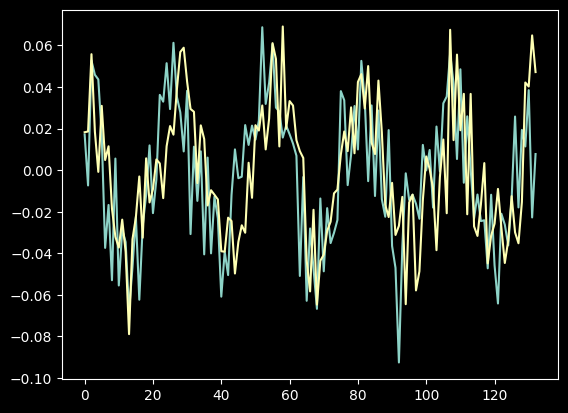

In [6]:
plt.plot(s1[:5*fs//f])
plt.plot(s2[:5*fs//f])
plt.show()

In [7]:
corr12 = signal.correlate(s1, s2)
corr12 = corr12 / np.max(corr12)
lags12 = signal.correlation_lags(len(s1), len(s2))
lag12 = lags12[np.argmax(corr12)] / fs

corr13 = signal.correlate(s2, s3)
corr13 = corr13 / np.max(corr13)
lags23 = signal.correlation_lags(len(s2), len(s3))
lag23 = lags23[np.argmax(corr13)] / fs

phi12, phi23 = t12 * f, t23 * f
phi12_frac, phi23_frac = lag12 * f, lag23 * f
phi12_frac, phi23_frac = np.mod(phi12_frac + 0.5, 1) - 0.5, np.mod(phi23_frac + 0.5, 1) - 0.5

In [8]:
print(f'真实相位差phi12: {phi12}\n相关相位差phi12\': {phi12_frac}\n差异: {np.abs(phi12 - phi12_frac) / phi12 * 100:.2f}%')
print(f'真实相位差phi23: {phi23}\n相关相位差phi23\': {phi23_frac}\n差异: {np.abs(phi23 - phi23_frac) / phi23 * 100:.2f}%')

真实相位差phi12: 1.932108532005827
相关相位差phi12': -0.07500000000000001
差异: 103.88%
真实相位差phi23: 2.0531546707049486
相关相位差phi23': 0.03749999999999998
差异: 98.17%


In [9]:
# scale = 40
# plt.plot(lags12[::fs//scale], corr12[::fs//scale])
# plt.show()

In [10]:
phi12_ar, phi23_ar = algorithm.ambiguity_resolution(np.array([phi12_frac]), np.array([phi23_frac]), K, d)
phi12_ar, phi23_ar = phi12_ar[0], phi23_ar[0]

In [11]:
print(f'真实相位差phi12: {phi12}\n解模糊后相位差phi12_ar\': {phi12_ar}\n差异: {np.abs(phi12 - phi12_ar) / phi12 * 100:.2f}%')
print(f'真实相位差phi23: {phi23}\n解模糊后相位差phi23_ar\': {phi23_ar}\n差异: {np.abs(phi23 - phi23_ar) / phi23 * 100:.2f}%')

真实相位差phi12: 1.932108532005827
解模糊后相位差phi12_ar': 1.925
差异: 0.37%
真实相位差phi23: 2.0531546707049486
解模糊后相位差phi23_ar': 2.0375
差异: 0.76%


In [12]:
r_e, theta_e = algorithm.far_locate(phi12_ar / f, phi23_ar/f, c, K, d)
# 可视化
print(f'真实方位角: {theta/pi*180}度\n估计方位角: {theta_e/pi*180}度\n绝对误差: {theta/pi*180 - theta_e/pi*180}度\n相对误差: {(theta - theta_e)/theta * 100}%')
# print(algorithm.far_locate(t12, t23, c, K, d))

真实方位角: 50.0度
估计方位角: 50.27429731036452度
绝对误差: -0.274297310364517度
相对误差: -0.5485946207290402%
